# Dataset Preparation

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed

Dataset URL: https://www.kaggle.com/datasets/prahladmehandiratta/cervical-cancer-largest-dataset-sipakmed
License(s): other
100% 6.39G/6.40G [01:22<00:00, 88.3MB/s]
100% 6.40G/6.40G [01:22<00:00, 82.9MB/s]


In [ ]:
import zipfile
import os

# Unzip the dataset
with zipfile.ZipFile('cervical-cancer-largest-dataset-sipakmed.zip', 'r') as zip_ref:
    zip_ref.extractall('sipakmed_dataset')

# Check the extracted files
os.listdir('sipakmed_dataset')

['im_Parabasal',
 'im_Metaplastic',
 'im_Superficial-Intermediate',
 'im_Dyskeratotic',
 'im_Koilocytotic']

In [ ]:
#Basic libraries
import os
import numpy as np
import pandas as pd
import copy
import random
import matplotlib.pyplot as plt
from collections import OrderedDict

#Framework
import torch
import torchvision

#data and its management related libraries
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from torchvision.transforms.functional import normalize
from PIL import Image #python imaging library
import cv2

# Required
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#for creating neural networks
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

#for optimising neural networks
import torch.optim as optim

#for metrics and analysis
import sklearn
from torchsummary import summary

In [ ]:
use_cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
print("Device in Use:",device)

Using PyTorch version: 2.3.1+cu121 CUDA: True
Device in Use: cuda


In [ ]:
import os
import shutil
import random

# Base paths
base_dir = "/content/sipakmed_dataset"
categories = ["im_Dyskeratotic", "im_Koilocytotic", "im_Metaplastic", "im_Parabasal", "im_Superficial-Intermediate"]

In [ ]:
# Function to get all main image paths and modified category names
def get_image_paths_and_categories(category):
    main_image_dir = os.path.join(base_dir, category, category)

    # Extract category name for the DataFrame
    category_name = category.replace("im_", "")

    # Prepare lists to hold image paths and category names
    image_paths = []
    categories = []

    # List all files in the main image directory
    for file_name in os.listdir(main_image_dir):
        if file_name.endswith(".bmp"):
            image_path = os.path.join(main_image_dir, file_name)
            image_paths.append(image_path)
            categories.append(category_name)

    return image_paths, categories

# Collect all image paths and categories
all_main_image_paths = []
all_categories = []

for category in categories:
    image_paths, category_names = get_image_paths_and_categories(category)
    all_main_image_paths.extend(image_paths)
    all_categories.extend(category_names)

# Create a DataFrame
images = pd.DataFrame({
    "Image Path": all_main_image_paths,
    "Category": all_categories
})

In [ ]:
import os
import pandas as pd

# Prepare lists to hold image paths, cyt.dat paths, nuc.dat paths, and categories
cropped_image_paths = []
cyt_dat_paths = []
nuc_dat_paths = []
categories_list = []

# Function to find and pair cropped images with their cyt.dat and nuc.dat files
def find_cropped_images_and_dat_files(category):
    cropped_image_dir = os.path.join(base_dir, category, category, "CROPPED")

    # List all files in the CROPPED directory
    for file_name in os.listdir(cropped_image_dir):
        if file_name.endswith(".bmp"):
            image_path = os.path.join(cropped_image_dir, file_name)

            # Derive the base name (without extension) to find corresponding dat files
            base_name = os.path.splitext(file_name)[0]

            # Construct the expected paths for cyt.dat and nuc.dat
            cyt_dat_path = os.path.join(cropped_image_dir, f"{base_name}_cyt.dat")
            nuc_dat_path = os.path.join(cropped_image_dir, f"{base_name}_nuc.dat")

            # Only add if both corresponding .dat files exist
            if os.path.exists(cyt_dat_path) and os.path.exists(nuc_dat_path):
                cropped_image_paths.append(image_path)
                cyt_dat_paths.append(cyt_dat_path)
                nuc_dat_paths.append(nuc_dat_path)

                # Extract category name and add to the list
                category_name = category.replace("im_", "")
                categories_list.append(category_name)

# Iterate over each category and collect the paths
for category in categories:
    find_cropped_images_and_dat_files(category)

# Create a DataFrame
cropped_images = pd.DataFrame({
    "Cropped Image Path": cropped_image_paths,
    "Cyt.dat Path": cyt_dat_paths,
    "Nuc.dat Path": nuc_dat_paths,
    "Category_Name": categories_list,
})

# Save the DataFrame to a CSV file for future use
# df.to_csv("cropped_images_data.csv", index=False)

In [ ]:
import pandas as pd

# Assuming you have a list of unique categories
categories = ['Parabasal', 'Koilocytotic', 'Dyskeratotic', 'Metaplastic', 'Superficial-Intermediate']

# Create a mapping from categories to numerical values
category_mapping = {category: i for i, category in enumerate(categories)}

# Apply the mapping to the 'Category' column
cropped_images['Category'] = cropped_images['Category_Name'].map(category_mapping)

In [ ]:
cropped_images.head()

,Cropped Image Path,Cyt.dat Path,Nuc.dat Path,Category_Name,Category
0,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,Dyskeratotic,2
1,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,Dyskeratotic,2
2,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,Dyskeratotic,2
3,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,Dyskeratotic,2
4,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,/content/sipakmed_dataset/im_Dyskeratotic/im_D...,Dyskeratotic,2


# Custom Dataset

In [ ]:
class custom_dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = self.df['Cropped Image Path'].tolist()
        self.labels = self.df['Category'].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        label = self.labels[index]

        # Apply transformations if needed
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transforms_ = transforms.Compose([v2.PILToTensor(),
                                v2.Resize((224,24),antialias=True),   # To resize into 3 X 28 X 28
                                lambda x:x.type(torch.float),  # To change data type to float
                                v2.RandomRotation(32), # To rotate image randomly from -32 degress to +32 degrees.
                                v2.RandomHorizontalFlip(32/100), # To apply random horizontal flipping with the probability 32/100.
  ])

In [ ]:
dataset_dummy = custom_dataset(cropped_images, transform=transforms_)
loader = DataLoader(dataset_dummy,
                         batch_size=len(dataset_dummy),
                         num_workers=0,
                         shuffle=False)

In [ ]:
for image, _ in loader:
  std , mean = torch.std_mean(image.type(torch.float),dim=0)

In [ ]:
def custom_dataloader(indices,cropped_images,size,batch_size=32,mean=mean,std=std,custom_dataset=custom_dataset):
  sampler = SubsetRandomSampler(indices)
  transforms_ = transforms.Compose([v2.PILToTensor(),
                                v2.Resize((size,size),antialias=True),   # To resize into 3 X 28 X 28
                                lambda x:x.type(torch.float),  # To change data type to float
                                v2.RandomRotation(32), # To rotate image randomly from -32 degress to +32 degrees.
                                v2.RandomHorizontalFlip(32/100), # To apply random horizontal flipping with the probability 32/100.
  ])
  dataset = custom_dataset(cropped_images, transform=transforms_)
  dataloader = DataLoader(dataset,
                          batch_size=batch_size,
                          num_workers=2,
                          sampler = sampler,
                          shuffle=False)
  return dataset, dataloader

In [ ]:
seed = 101
np.random.seed(seed)
torch.manual_seed(seed)
indices = np.random.permutation(4049)  # Generate a shuffled array of indices
train_indices, validation_indices, test_indices = indices[:3240], indices[3240:3644], indices[3644:4049]
train_dataset, train_dataloader = custom_dataloader(train_indices,cropped_images, size=32)
validation_dataset, validation_dataloader = custom_dataloader(validation_indices,cropped_images, size = 32)
test_dataset, test_dataloader = custom_dataloader(test_indices, cropped_images, size=32)

In [ ]:
for image, labels in validation_dataloader:
  print(image.shape)
  print(labels)
  break

torch.Size([32, 3, 32, 32])
tensor([1, 4, 4, 2, 2, 2, 2, 0, 0, 3, 3, 4, 0, 4, 4, 4, 3, 0, 4, 4, 1, 3, 1, 0,
        3, 4, 1, 1, 3, 1, 0, 4])


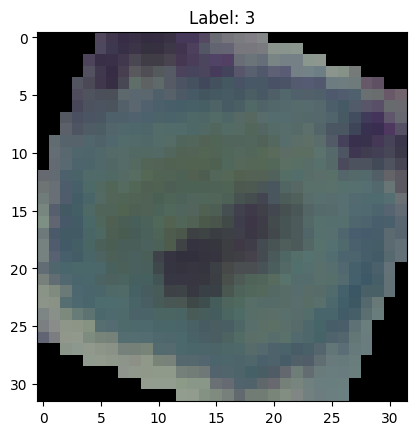

In [ ]:
import matplotlib.pyplot as plt

# Get one batch from the train_dataloader
images, labels = next(iter(train_dataloader))

# Choose an index to display the image (usually 0 for the first image)
index = 0

# Access the image and label at the chosen index
image = images[index]
label = labels[index]

# Assuming the image is a PyTorch tensor, convert it to a numpy array for display
image = image.numpy()

# Image is likely in CHW format (channels, height, width). Convert to HWC for display.
image = np.transpose(image, (1, 2, 0))

# Clip pixel values to 0-255 for display
image = np.clip(image, 0, 255).astype(np.uint8)

# Display the image and label
plt.imshow(image)
plt.title(f"Label: {label}")
plt.show()

# Training Neural Networks

In [ ]:
class CNN(torch.nn.Module):
	def __init__(self):
		super().__init__()
		# --- Conv layer Set 1
		self.l1_conv = torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1) # 3 * 32 * 32 ----> Conv2D : 32c3w1s1p ---->
		self.l1_relu = torch.nn.ReLU()    #  ----> ReLU --->
		self.l1_maxpool = torch.nn.MaxPool2d(kernel_size=2) # ----> Maxpool2D : 2w1s0p --->
		# --- Conv layer Set 2
		self.l2_conv = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)   #  ----> Conv2D : 64c3w1s1p ---->
		self.l2_relu = torch.nn.ReLU()		#     ----> ReLU --->
		self.l2_maxpool = torch.nn.MaxPool2d(kernel_size=2) #    ----> Maxpool2D : 2w1s0p --->
		# --- Conv layer Set 3
		self.l3_conv = torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1)	#  ----> Conv2D : 64c3w1s1p ---->
		self.l3_relu = torch.nn.ReLU()				#     ----> ReLU --->
		self.l3_maxpool = torch.nn.MaxPool2d(kernel_size=2)		#    ----> Maxpool2D : 2w1s0p --->
		# --- FCL
		self.fc_flat = torch.nn.Flatten()			# ------> Flatten ----->
		self.fc_lin1 = torch.nn.Linear(64*4*4, 512)		#  ---------> Linear(512) ------>
		self.fc_relu = torch.nn.ReLU()                #  ---------> ReLu ------->
		self.fc_lin2 = torch.nn.Linear(512, 5)				# ----------> Linear(10) ------>
	def forward(self, x):
		# --- Conv layer Set 1
		x = self.l1_conv(x)
		x = self.l1_relu(x)
		x = self.l1_maxpool(x)
		# ---- Conv layer Set 2
		x = self.l2_conv(x)
		x = self.l2_relu(x)
		x = self.l2_maxpool(x)
		# ---- Conv layer Set 3
		x = self.l3_conv(x)
		x = self.l3_relu(x)
		x = self.l3_maxpool(x)
		# FC layer
		x = self.fc_flat(x)
		x = self.fc_lin1(x)
		x = self.fc_relu(x)
		x = self.fc_lin2(x)
		return x

# Printing model summary

from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_to_analyse = CNN().to(device)
print(model_to_analyse)

summary(model_to_analyse, (3, 32, 32))

CNN(
  (l1_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l1_relu): ReLU()
  (l1_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l2_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l2_relu): ReLU()
  (l2_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l3_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l3_relu): ReLU()
  (l3_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_flat): Flatten(start_dim=1, end_dim=-1)
  (fc_lin1): Linear(in_features=1024, out_features=512, bias=True)
  (fc_relu): ReLU()
  (fc_lin2): Linear(in_features=512, out_features=5, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1

In [ ]:
import torch
import torch.nn.functional as F  # For one-hot encoding (if needed)
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# Replace `OptimizedCNN` with your actual CNN model class
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
model = CNN().to(device)

# Model hyperparameters
num_epochs = 50
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Early Stopping Parameters
patience = 5  # Number of epochs to wait before stopping if no improvement
best_valid_loss = float('inf')
patience_counter = 0

# Loss history for tracking
train_loss_history = []
valid_loss_history = []

start_time = time.time()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:', end=' ')

    # Training phase
    model.train()
    running_train_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Validation phase
    model.eval()
    running_valid_loss = 0.0
    with torch.no_grad():
        for images, labels in validation_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()

    # Calculate average losses
    avg_train_loss = running_train_loss / len(train_dataloader)
    avg_valid_loss = running_valid_loss / len(validation_dataloader)

    train_loss_history.append(avg_train_loss)
    valid_loss_history.append(avg_valid_loss)

    # Print losses for this epoch
    print(f"training_loss: {avg_train_loss:.3f} validation_loss: {avg_valid_loss:.3f}")

    # Early Stopping Check
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        patience_counter = 0  # Reset the counter if validation loss improves
    else:
        patience_counter += 1  # Increment the counter if no improvement
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break  # Stop training

end_time = time.time()
training_time = end_time - start_time
print(f"Finished Training. Total time: {training_time:.2f} seconds")

Using device: cuda
Epoch 1/50: training_loss: 1.431 validation_loss: 0.767
Epoch 2/50: training_loss: 0.794 validation_loss: 1.212
Epoch 3/50: training_loss: 0.779 validation_loss: 0.616
Epoch 4/50: training_loss: 0.637 validation_loss: 0.957
Epoch 5/50: training_loss: 0.554 validation_loss: 0.496
Epoch 6/50: training_loss: 0.526 validation_loss: 0.651
Epoch 7/50: training_loss: 0.476 validation_loss: 0.605
Epoch 8/50: training_loss: 0.471 validation_loss: 0.494
Epoch 9/50: training_loss: 0.445 validation_loss: 0.497
Epoch 10/50: training_loss: 0.421 validation_loss: 0.538
Epoch 11/50: training_loss: 0.397 validation_loss: 0.466
Epoch 12/50: training_loss: 0.348 validation_loss: 0.534
Epoch 13/50: training_loss: 0.391 validation_loss: 0.570
Epoch 14/50: training_loss: 0.382 validation_loss: 0.456
Epoch 15/50: training_loss: 0.330 validation_loss: 0.368
Epoch 16/50: training_loss: 0.331 validation_loss: 0.376
Epoch 17/50: training_loss: 0.323 validation_loss: 0.599
Epoch 18/50: training

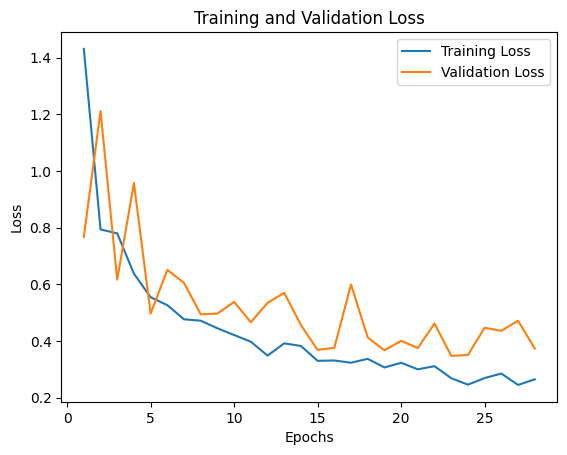

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss curves
epochs_trained = len(train_loss_history)  # Number of epochs actually trained

plt.plot(range(1, epochs_trained + 1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs_trained + 1), valid_loss_history, label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Switch model to evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation for evaluation
    for images, labels in test_dataloader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass to get predictions
        outputs = model(images)

        # Get the predicted class (index of the max logit)
        _, preds = torch.max(outputs, 1)

        # Store predictions and actual labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy using sklearn's accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 89.38%


# FEATURE EXTRACTION

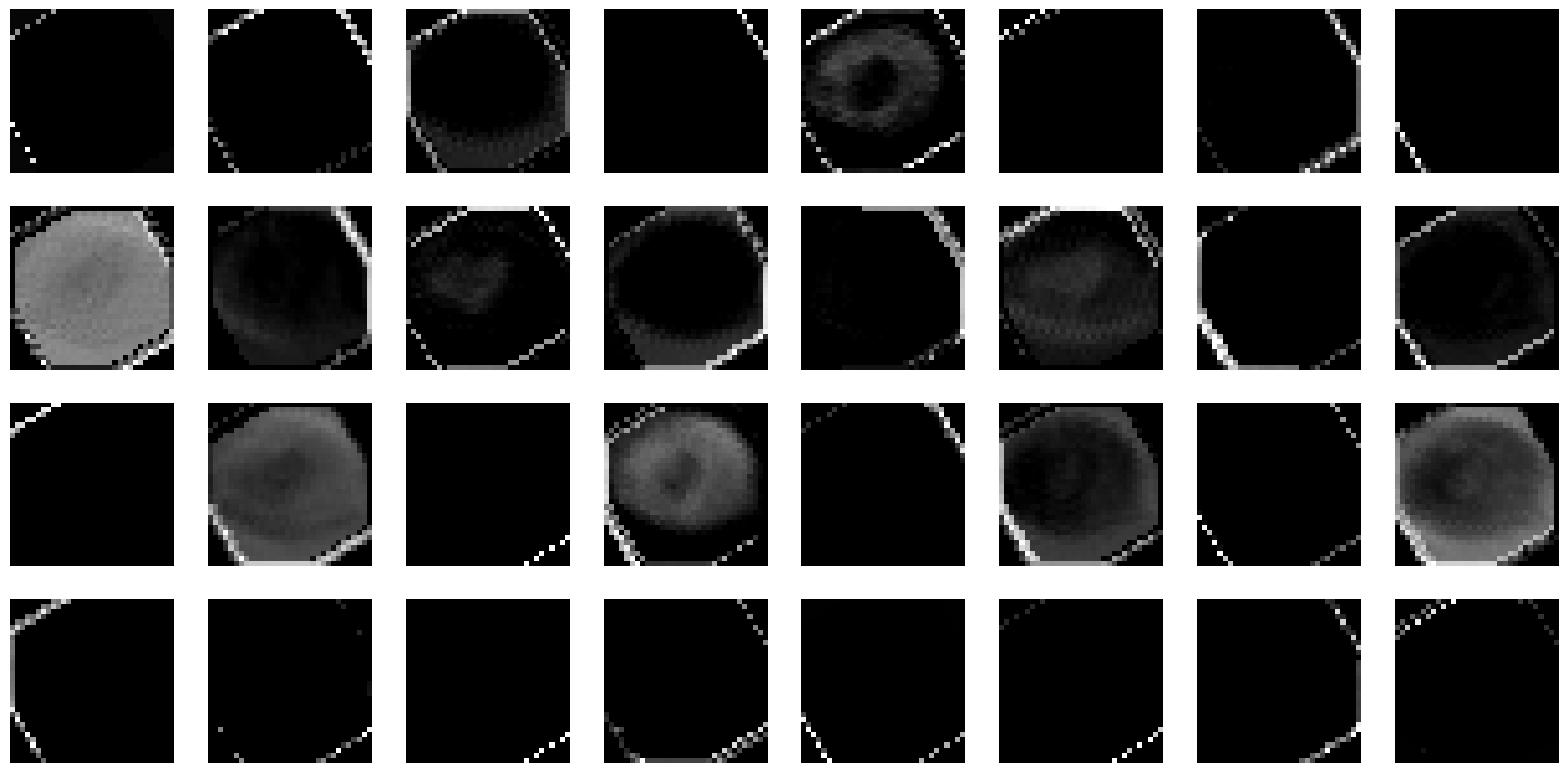

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_feature_maps(model, image):
    # Set the model to evaluation mode
    model.eval()

    # Ensure the image is on the correct device
    image = image.to(device)

    # Pass the image through the first convolutional layer
    x = model.l1_conv(image)
    x = model.l1_relu(x)

    # Detach and move the feature maps to CPU
    feature_maps = x.detach().cpu()

    # Plot the feature maps
    num_feature_maps = feature_maps.shape[1]
    plt.figure(figsize=(20, 20))
    for i in range(num_feature_maps):
        plt.subplot(8, 8, i+1)  # Adjust based on num_feature_maps
        plt.imshow(feature_maps[0, i], cmap='gray')
        plt.axis('off')
    plt.show()

# Assuming you have a single image from the dataset
image, _ = next(iter(test_dataloader))  # Get one batch of images
image = image[:1]  # Take the first image from the batch

# Visualize the feature maps
visualize_feature_maps(model, image)

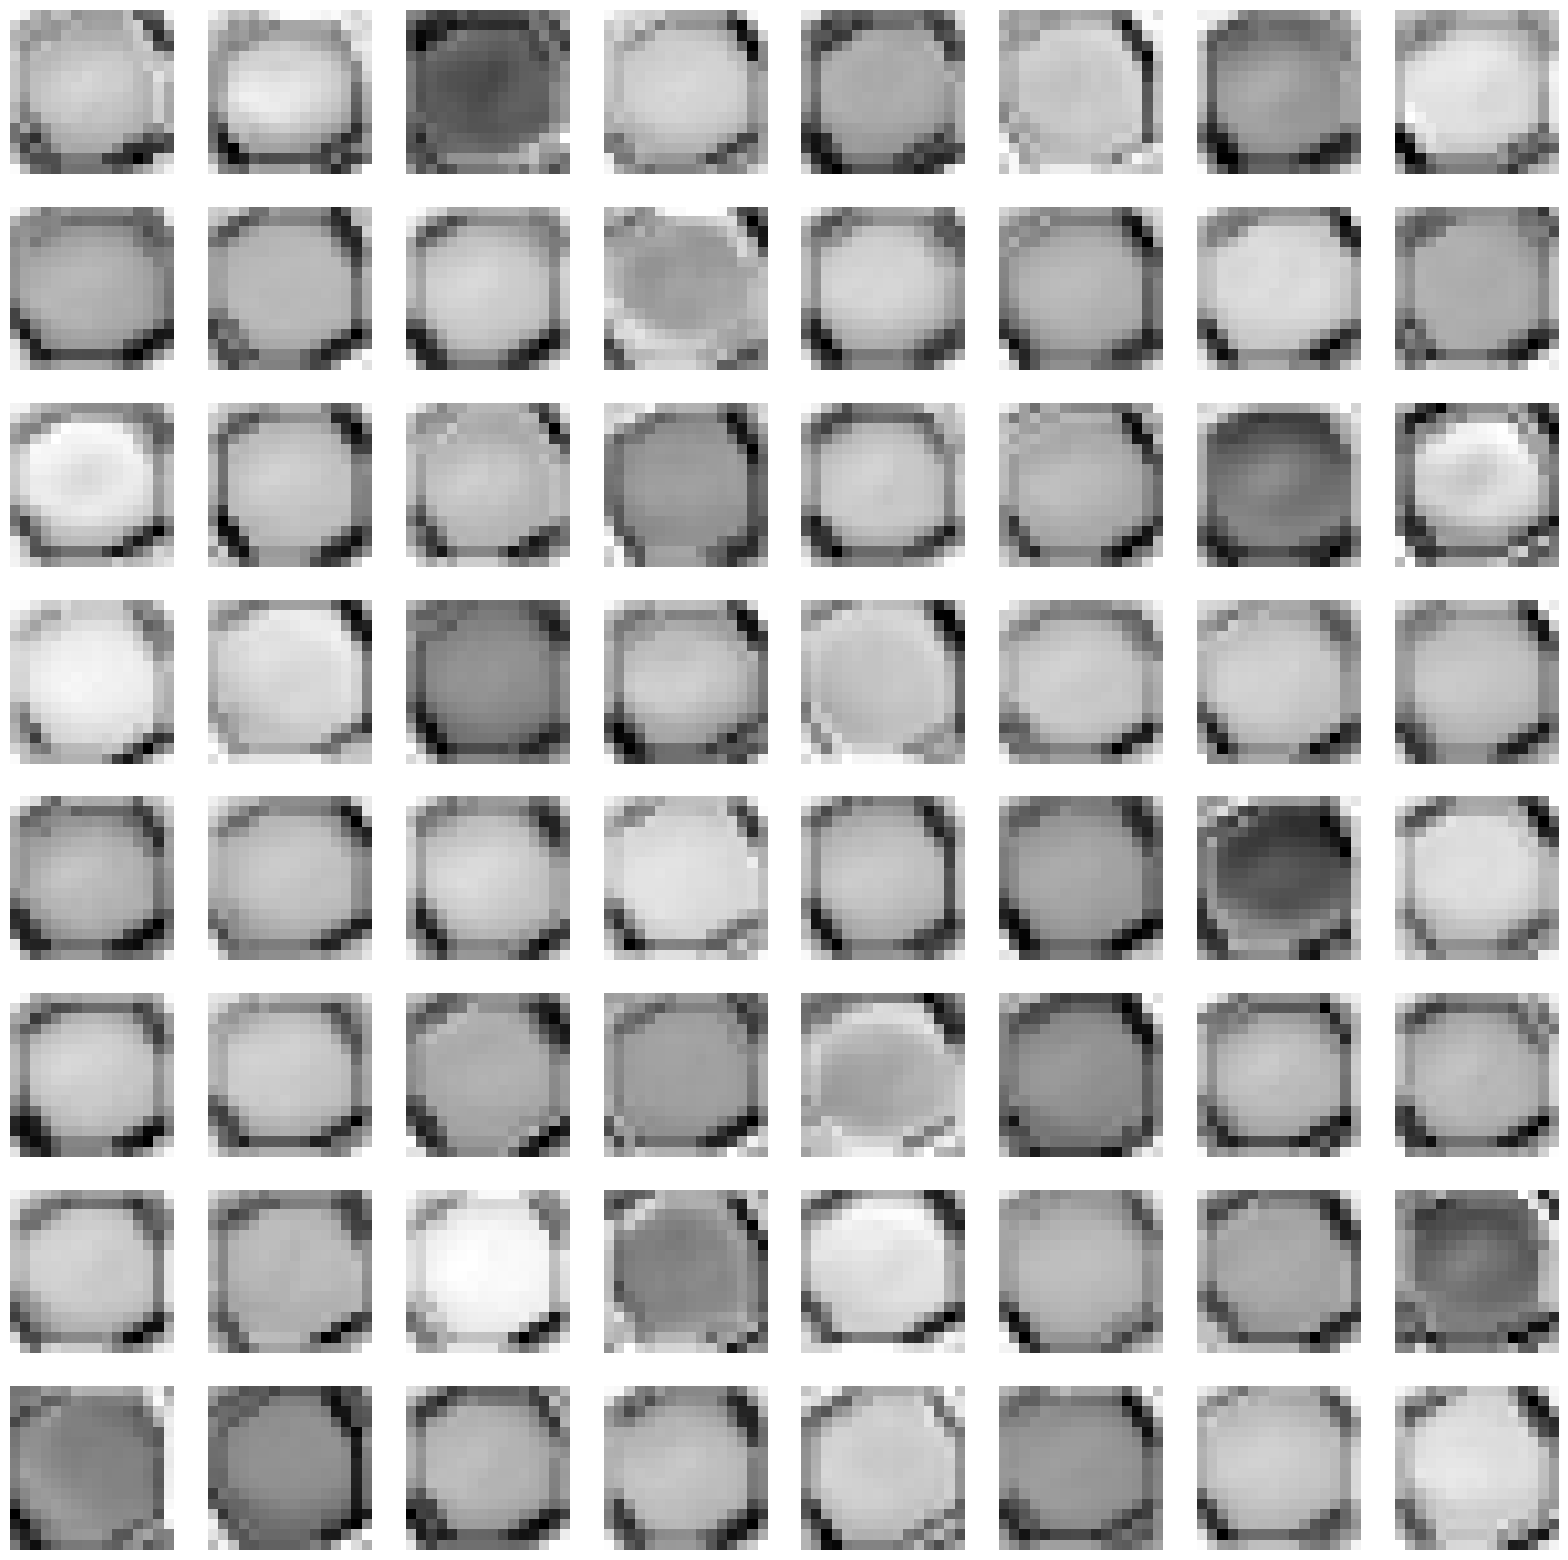

In [ ]:
def get_layer_output(model, image, layer_name):
    model.eval()

    image = image.to(device)

    # Forward pass to get outputs
    x = image
    for name, layer in model.named_children():
        x = layer(x)
        if name == layer_name:
            break

    return x.detach().cpu()

# Example: Get output from the second convolutional layer
layer_name = "l2_conv"
output = get_layer_output(model, image, layer_name)

# Plot the outputs
num_outputs = output.shape[1]
plt.figure(figsize=(20, 20))
for i in range(num_outputs):
    plt.subplot(8, 8, i+1)
    plt.imshow(output[0, i], cmap='gray')
    plt.axis('off')
plt.show()

<Figure size 640x480 with 0 Axes>

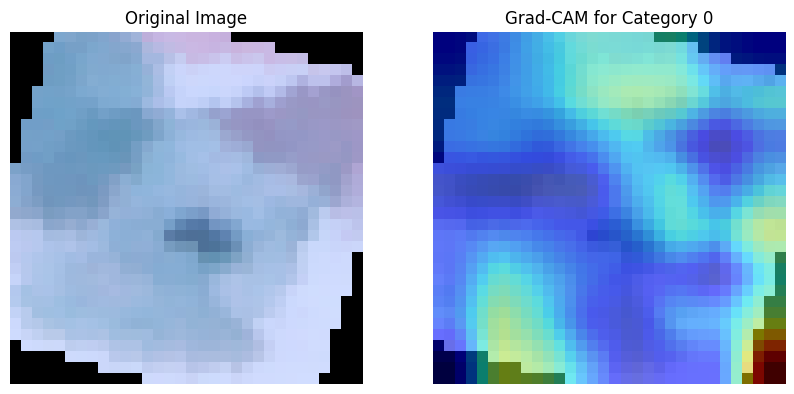

<Figure size 640x480 with 0 Axes>

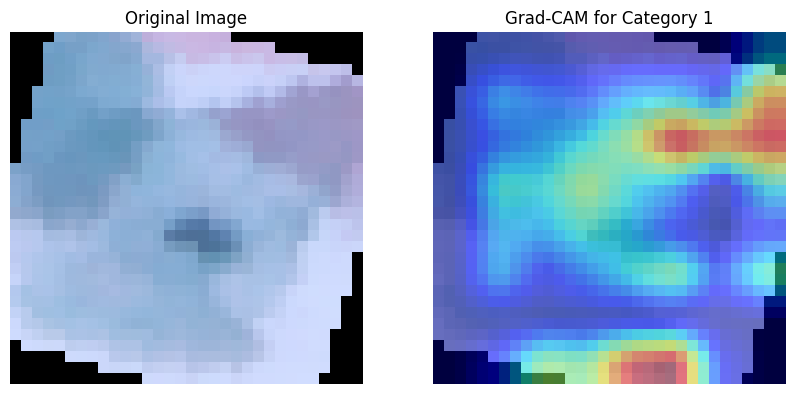

<Figure size 640x480 with 0 Axes>

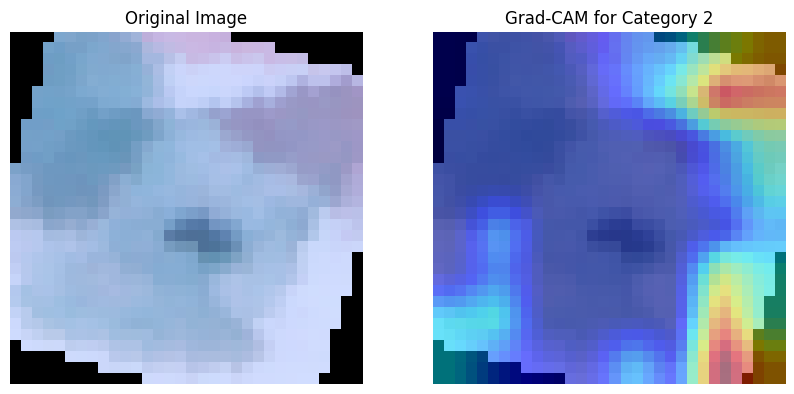

<Figure size 640x480 with 0 Axes>

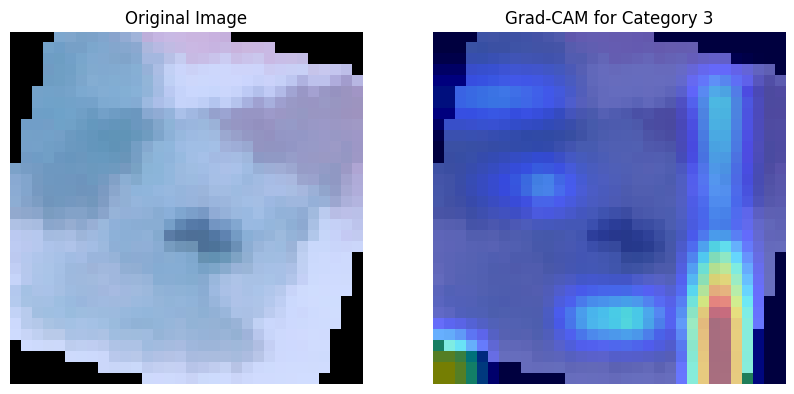

<Figure size 640x480 with 0 Axes>

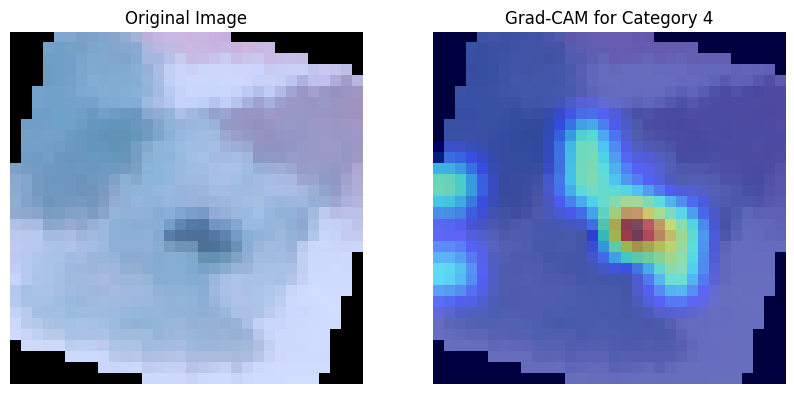

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def grad_cam(model, image, target_class):
    model.eval()
    image = image.to(device)
    target_class = torch.tensor([target_class]).to(device)

    # Forward pass up to the last convolutional layer
    x = image
    conv_output = None  # Placeholder to capture the output of the last convolutional layer
    for name, layer in model.named_children():
        x = layer(x)
        if name == 'l3_conv':  # The last convolutional layer
            conv_output = x  # Capture the output for gradient calculation
            conv_output.retain_grad()  # Explicitly retain the gradient for this tensor
            break

    # Complete the forward pass using the remaining layers
    x = model.l3_relu(conv_output)
    x = model.l3_maxpool(x)
    x = model.fc_flat(x)
    x = model.fc_lin1(x)
    x = model.fc_relu(x)
    outputs = model.fc_lin2(x)

    # Zero the gradients
    model.zero_grad()

    # Perform backward pass to get gradients with respect to target class
    outputs[:, target_class].backward()

    # Get the gradients from the last convolutional layer
    gradients = conv_output.grad.cpu().data.numpy()[0]

    # Pool the gradients across the channels
    pooled_gradients = np.mean(gradients, axis=(1, 2))

    # Get the convolutional output
    feature_maps = conv_output.cpu().data.numpy()[0]

    # Weight the feature maps with the pooled gradients
    for i in range(pooled_gradients.size):
        feature_maps[i] *= pooled_gradients[i]

    # Create the heatmap
    heatmap = np.mean(feature_maps, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Resize the heatmap to match the input image size
    heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[3]))

    return heatmap

# Example usage:
image, label = next(iter(test_dataloader))  # Get one batch of images and labels
image = image[:1]  # Take the first image from the batch
label = label[:1]  # Corresponding label for that image

# Normalize the image to [0, 1] range if it's not already
image_np = image[0].cpu().numpy()  # Convert to NumPy array
if image_np.max() > 1.0:
    image_np = image_np / 255.0  # Normalize if necessary

# Iterate through all the categories
num_classes = 5  # Assuming you have 5 categories
for target_class in range(num_classes):
    heatmap = grad_cam(model, image, target_class)  # Generate Grad-CAM for each category

    # Create a side-by-side comparison
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Original Image
    axs[0].imshow(image_np.transpose(1, 2, 0))  # Original image (now in [0, 1] range)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Grad-CAM Heatmap
    axs[1].imshow(image_np.transpose(1, 2, 0))  # Original image
    axs[1].imshow(heatmap, cmap='jet', alpha=0.5)  # Heatmap
    axs[1].set_title(f'Grad-CAM for Category {target_class}')
    axs[1].axis('off')

    plt.show()
    # Optional: Save the combined image
    plt.savefig(f'grad_cam_comparison_category_{target_class}.png')


CNN(
  (l1_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l1_relu): ReLU()
  (l1_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l2_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l2_relu): ReLU()
  (l2_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (l3_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l3_relu): ReLU()
  (l3_maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_flat): Flatten(start_dim=1, end_dim=-1)
  (fc_lin1): Linear(in_features=1024, out_features=512, bias=True)
  (fc_relu): ReLU()
  (fc_lin2): Linear(in_features=512, out_features=5, bias=True)
)
l1_conv.weight
torch.Size([32, 3, 3, 3])


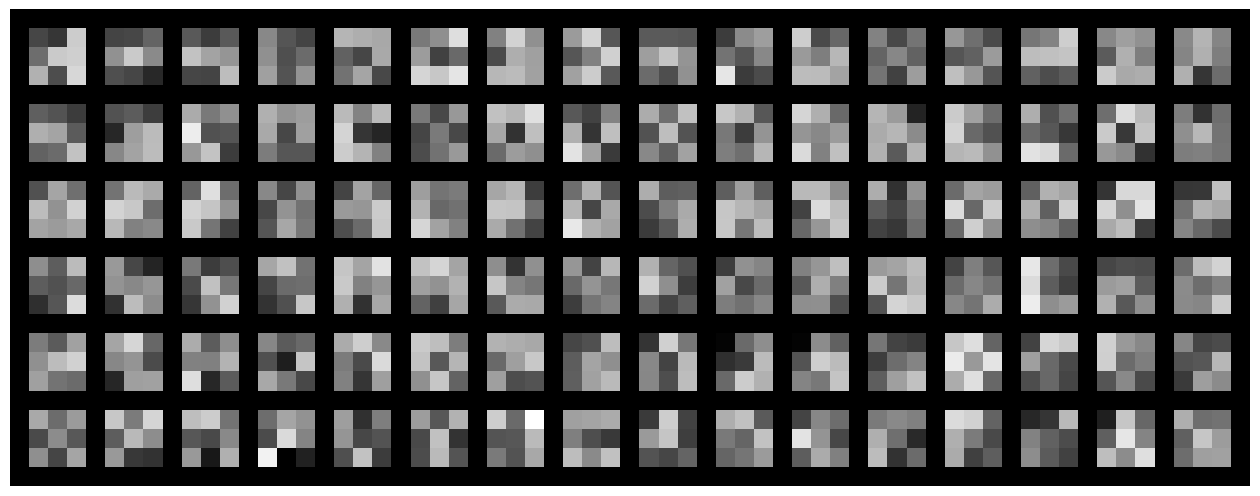

l2_conv.weight
torch.Size([64, 32, 3, 3])


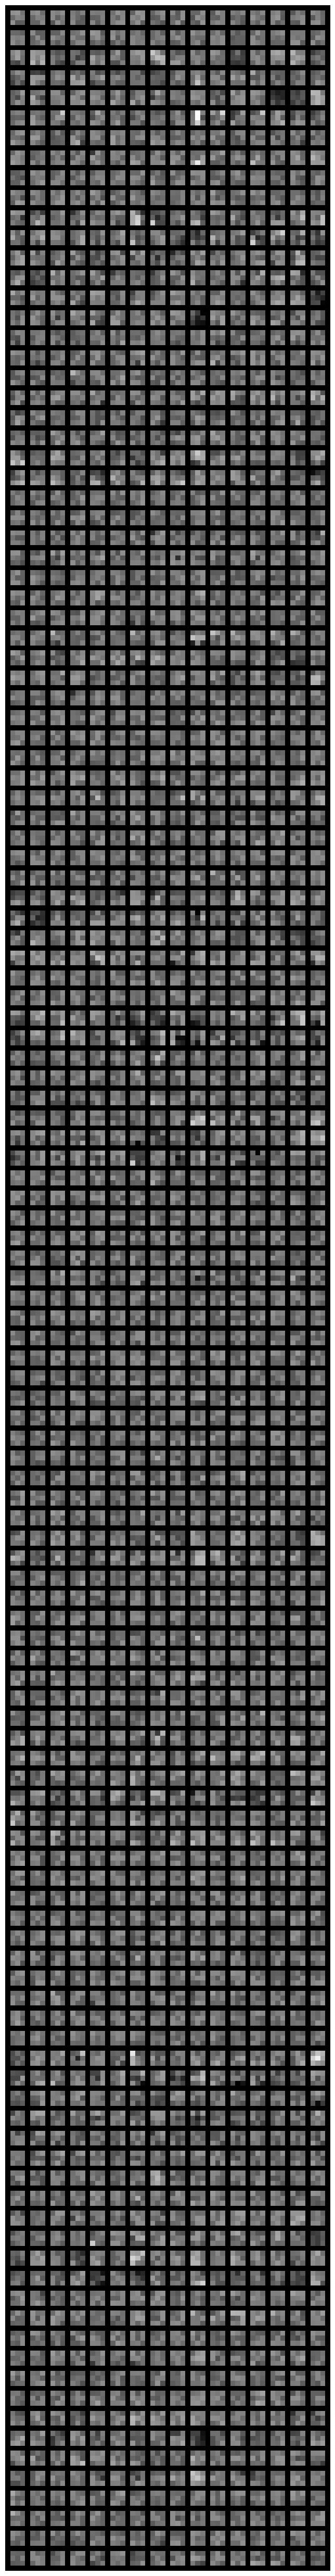

l3_conv.weight
torch.Size([64, 64, 3, 3])


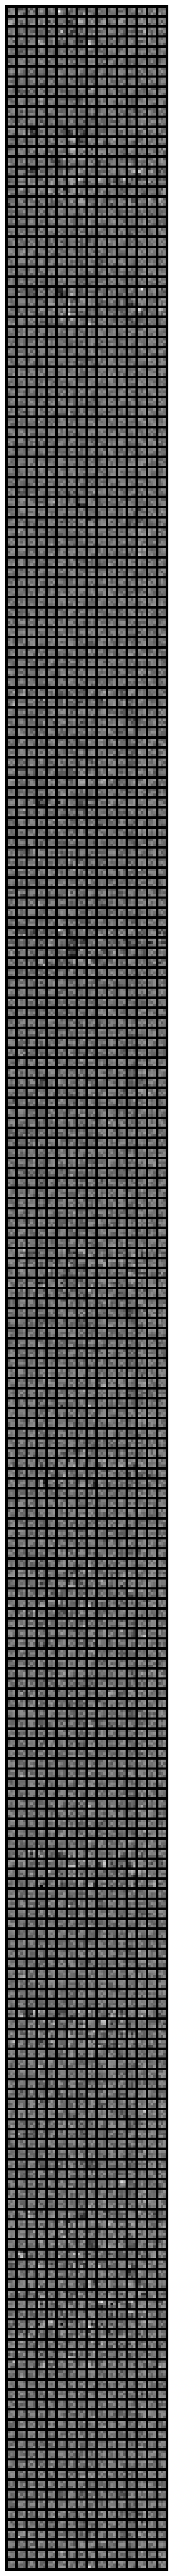

In [ ]:
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=16, padding=1, normalize=True):
  print(tensor.shape)
  n,c,w,h = tensor.shape
  tensor = tensor.view(n*c, -1, w, h)
  #if allkernels: tensor = tensor.view(n*c, -1, w, h)
  #elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
  rows = np.min((tensor.shape[0] // nrow + 1, 64))
  grid = utils.make_grid(tensor, nrow=nrow, normalize=normalize, padding=padding)
  plt.figure( figsize=(nrow,rows) )
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

print(model)

for name, param in model.named_parameters():
  # print(name, param)
  if 'conv' in name.lower() and 'weight' in name.lower(): #and '3' in name.lower():  # Getting convolution filters only
    print(name)
    visTensor(param.detach().cpu(), ch=0, allkernels=True)
    plt.axis('off')
    plt.ioff()
    plt.show()



# 20/08/2024

In [ ]:
train_dataset, train_dataloader = custom_dataloader(train_indices,cropped_images, size=224)
validation_dataset, validation_dataloader = custom_dataloader(validation_indices,cropped_images, size = 224)
test_dataset, test_dataloader = custom_dataloader(test_indices, cropped_images, size=224)

# Resent-18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import copy

# Define the ResNet Model class
class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        # Load the pre-trained ResNet-18 model
        self.model = models.resnet18(pretrained=True)
        # Replace the final fully connected layer to match the number of output classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of classes (assuming you have a dictionary or mapping for categories)
num_classes = 5  # Replace with your actual number of categories

# Instantiate the model
model_resnet18 = ResNetModel(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=0.001)

# Early Stopping parameters
patience = 5  # Number of epochs to wait before stopping if no improvement
best_loss = float('inf')  # Initialize the best loss to infinity
best_model_wts = copy.deepcopy(model_resnet18.state_dict())  # Copy initial model weights
patience_counter = 0  # Counter to keep track of epochs with no improvement

# Training loop with Early Stopping
num_epochs = 50  # Set a larger number of epochs to allow early stopping to work
for epoch in range(num_epochs):
    model_resnet18.train()
    running_train_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_resnet18(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Validation phase
    model_resnet18.eval()
    running_valid_loss = 0.0
    with torch.no_grad():
        for images, labels in validation_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet18(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()

    # Calculate average losses
    avg_train_loss = running_train_loss / len(train_dataloader)
    avg_valid_loss = running_valid_loss / len(validation_dataloader)

    # Print losses for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f}')

    # Early Stopping logic
    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        best_model_wts = copy.deepcopy(model_resnet18.state_dict())
        patience_counter = 0  # Reset the counter if validation loss improves
    else:
        patience_counter += 1
        print(f'Early stopping counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model weights before saving
model_resnet18.load_state_dict(best_model_wts)

# Save the trained model
torch.save(model_resnet18.state_dict(), 'resnet_model_best.pth')

# Model summary (optional)
from torchsummary import summary
summary(model_resnet18, (3, 224, 224))  # ResNet expects 224x224 input images


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 59.7MB/s]


Epoch [1/50], Train Loss: 0.5726, Val Loss: 0.5523
Epoch [2/50], Train Loss: 0.3595, Val Loss: 0.3208
Epoch [3/50], Train Loss: 0.3250, Val Loss: 0.4808
Early stopping counter: 1/5
Epoch [4/50], Train Loss: 0.2785, Val Loss: 0.2566
Epoch [5/50], Train Loss: 0.2782, Val Loss: 0.6129
Early stopping counter: 1/5
Epoch [6/50], Train Loss: 0.2517, Val Loss: 0.2478
Epoch [7/50], Train Loss: 0.2161, Val Loss: 0.3966
Early stopping counter: 1/5
Epoch [8/50], Train Loss: 0.1978, Val Loss: 0.3118
Early stopping counter: 2/5
Epoch [9/50], Train Loss: 0.1575, Val Loss: 0.2286
Epoch [10/50], Train Loss: 0.1815, Val Loss: 0.3920
Early stopping counter: 1/5
Epoch [11/50], Train Loss: 0.1973, Val Loss: 0.2218
Epoch [12/50], Train Loss: 0.1409, Val Loss: 0.2454
Early stopping counter: 1/5
Epoch [13/50], Train Loss: 0.1120, Val Loss: 0.2105
Epoch [14/50], Train Loss: 0.1557, Val Loss: 0.4279
Early stopping counter: 1/5
Epoch [15/50], Train Loss: 0.1301, Val Loss: 0.1958
Epoch [16/50], Train Loss: 0.1342

Confusion Matrix:
[[73  0  0  0  0]
 [ 0 82  2  2  1]
 [ 1  1 72  0  0]
 [ 1  6  0 90  0]
 [ 0  2  1  0 71]]


<Figure size 640x480 with 0 Axes>

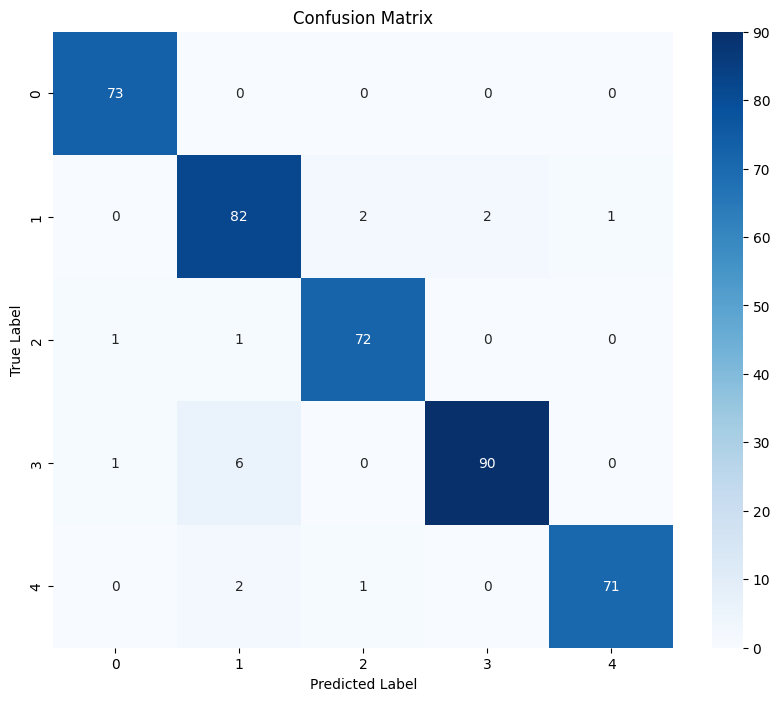

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      1.00      0.99        73
     Class 1       0.90      0.94      0.92        87
     Class 2       0.96      0.97      0.97        74
     Class 3       0.98      0.93      0.95        97
     Class 4       0.99      0.96      0.97        74

    accuracy                           0.96       405
   macro avg       0.96      0.96      0.96       405
weighted avg       0.96      0.96      0.96       405



In [ ]:
# Lists to store all true labels and predictions
all_labels = []
all_predictions = []

# Perform evaluation to get predictions for the entire test set
model_resnet18.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet18(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)]))


# Resent 50

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import copy

# Define ResNet-50 Model
class ResNet50Model(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Model, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of classes (assuming you have a dictionary or mapping for categories)
num_classes = 5  # Replace with your actual number of categories

# Instantiate the model
model_resnet50 = ResNet50Model(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=0.001)

# Early Stopping parameters
patience = 5  # Number of epochs to wait before stopping if no improvement
best_loss = float('inf')  # Initialize the best loss to infinity
best_model_wts = copy.deepcopy(model_resnet50.state_dict())  # Copy initial model weights
patience_counter = 0  # Counter to keep track of epochs with no improvement

# Training loop with Early Stopping
num_epochs = 50  # Set a larger number of epochs to allow early stopping to work
for epoch in range(num_epochs):
    model_resnet50.train()
    running_train_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model_resnet50(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Validation phase
    model_resnet50.eval()
    running_valid_loss = 0.0
    with torch.no_grad():
        for images, labels in validation_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet50(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()

    # Calculate average losses
    avg_train_loss = running_train_loss / len(train_dataloader)
    avg_valid_loss = running_valid_loss / len(validation_dataloader)

    # Print losses for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f}')

    # Early Stopping logic
    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        best_model_wts = copy.deepcopy(model_resnet50.state_dict())
        patience_counter = 0  # Reset the counter if validation loss improves
    else:
        patience_counter += 1
        print(f'Early stopping counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model weights before saving
model_resnet50.load_state_dict(best_model_wts)

# Save the trained model
torch.save(model_resnet50.state_dict(), 'resnet50_best.pth')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.9MB/s]


Epoch [1/50], Train Loss: 0.4966, Val Loss: 0.3766
Epoch [2/50], Train Loss: 0.2732, Val Loss: 0.3086
Epoch [3/50], Train Loss: 0.2093, Val Loss: 0.3299
Early stopping counter: 1/5
Epoch [4/50], Train Loss: 0.2016, Val Loss: 0.3311
Early stopping counter: 2/5
Epoch [5/50], Train Loss: 0.1471, Val Loss: 0.3553
Early stopping counter: 3/5
Epoch [6/50], Train Loss: 0.1325, Val Loss: 0.3420
Early stopping counter: 4/5
Epoch [7/50], Train Loss: 0.1303, Val Loss: 0.2087
Epoch [8/50], Train Loss: 0.1154, Val Loss: 0.2258
Early stopping counter: 1/5
Epoch [9/50], Train Loss: 0.1031, Val Loss: 0.2772
Early stopping counter: 2/5
Epoch [10/50], Train Loss: 0.0840, Val Loss: 0.1730
Epoch [11/50], Train Loss: 0.0968, Val Loss: 0.1680
Epoch [12/50], Train Loss: 0.1370, Val Loss: 0.1625
Epoch [13/50], Train Loss: 0.1248, Val Loss: 0.2303
Early stopping counter: 1/5
Epoch [14/50], Train Loss: 0.0803, Val Loss: 0.1763
Early stopping counter: 2/5
Epoch [15/50], Train Loss: 0.0701, Val Loss: 0.1527
Epoch

Confusion Matrix:
[[72  0  1  0  0]
 [ 0 82  0  4  1]
 [ 0  1 73  0  0]
 [ 1  1  0 95  0]
 [ 1  0  0  0 73]]


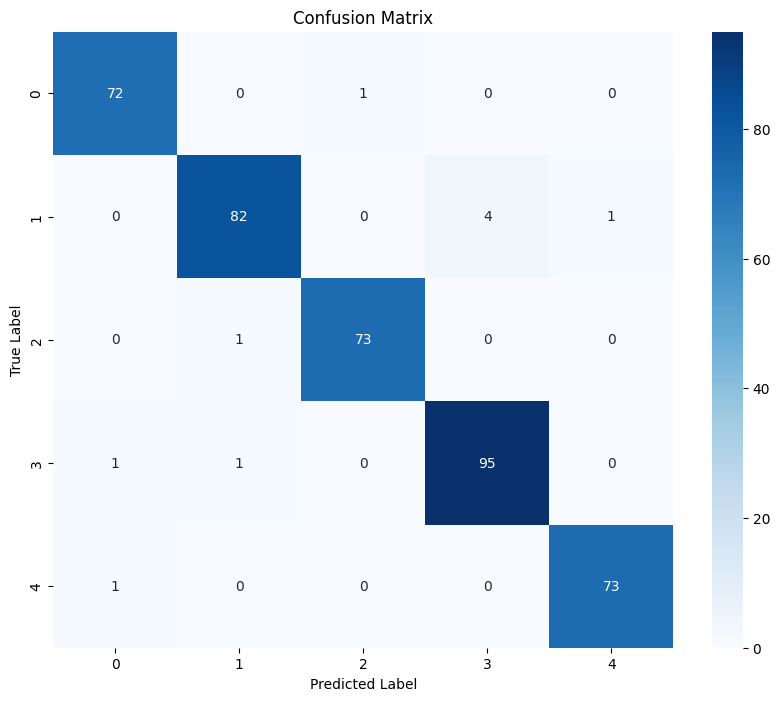

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.99      0.98        73
     Class 1       0.98      0.94      0.96        87
     Class 2       0.99      0.99      0.99        74
     Class 3       0.96      0.98      0.97        97
     Class 4       0.99      0.99      0.99        74

    accuracy                           0.98       405
   macro avg       0.98      0.98      0.98       405
weighted avg       0.98      0.98      0.98       405



In [ ]:
# Lists to store all true labels and predictions
all_labels = []
all_predictions = []

# Perform evaluation to get predictions for the entire test set
model_resnet50.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet50(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)]))

# Densenet 121

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import copy

# Define DenseNet-121 Model
class DenseNet121Model(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet121Model, self).__init__()
        self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of classes (assuming you have a dictionary or mapping for categories)
num_classes = 5  # Replace with your actual number of categories

# Instantiate the model
model = DenseNet121Model(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Early Stopping parameters
patience = 5  # Number of epochs to wait before stopping if no improvement
best_loss = float('inf')  # Initialize the best loss to infinity
best_model_wts = copy.deepcopy(model.state_dict())  # Copy initial model weights
patience_counter = 0  # Counter to keep track of epochs with no improvement

# Training loop with Early Stopping
num_epochs = 50  # Set a larger number of epochs to allow early stopping to work
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Validation phase
    model.eval()
    running_valid_loss = 0.0
    with torch.no_grad():
        for images, labels in validation_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_valid_loss += loss.item()

    # Calculate average losses
    avg_train_loss = running_train_loss / len(train_dataloader)
    avg_valid_loss = running_valid_loss / len(validation_dataloader)

    # Print losses for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f}')

    # Early Stopping logic
    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0  # Reset the counter if validation loss improves
    else:
        patience_counter += 1
        print(f'Early stopping counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model weights before saving
model.load_state_dict(best_model_wts)

# Save the trained model
torch.save(model.state_dict(), 'densenet121_best.pth')


Epoch [1/50], Train Loss: 0.4550, Val Loss: 0.3679
Epoch [2/50], Train Loss: 0.3193, Val Loss: 0.2515
Epoch [3/50], Train Loss: 0.2516, Val Loss: 0.2056
Epoch [4/50], Train Loss: 0.2148, Val Loss: 0.2378
Early stopping counter: 1/5
Epoch [5/50], Train Loss: 0.1924, Val Loss: 0.2485
Early stopping counter: 2/5
Epoch [6/50], Train Loss: 0.1808, Val Loss: 0.2003
Epoch [7/50], Train Loss: 0.1552, Val Loss: 0.2214
Early stopping counter: 1/5
Epoch [8/50], Train Loss: 0.1427, Val Loss: 0.3483
Early stopping counter: 2/5
Epoch [9/50], Train Loss: 0.1330, Val Loss: 0.2268
Early stopping counter: 3/5
Epoch [10/50], Train Loss: 0.1317, Val Loss: 0.2396
Early stopping counter: 4/5
Epoch [11/50], Train Loss: 0.1141, Val Loss: 0.4677
Early stopping counter: 5/5
Early stopping triggered


Validation Accuracy: 94.32%
Confusion Matrix:
[[72  0  0  1  0]
 [ 0 81  0  5  1]
 [ 0  2 72  0  0]
 [ 0  5  0 92  0]
 [ 0  0  0  1 73]]


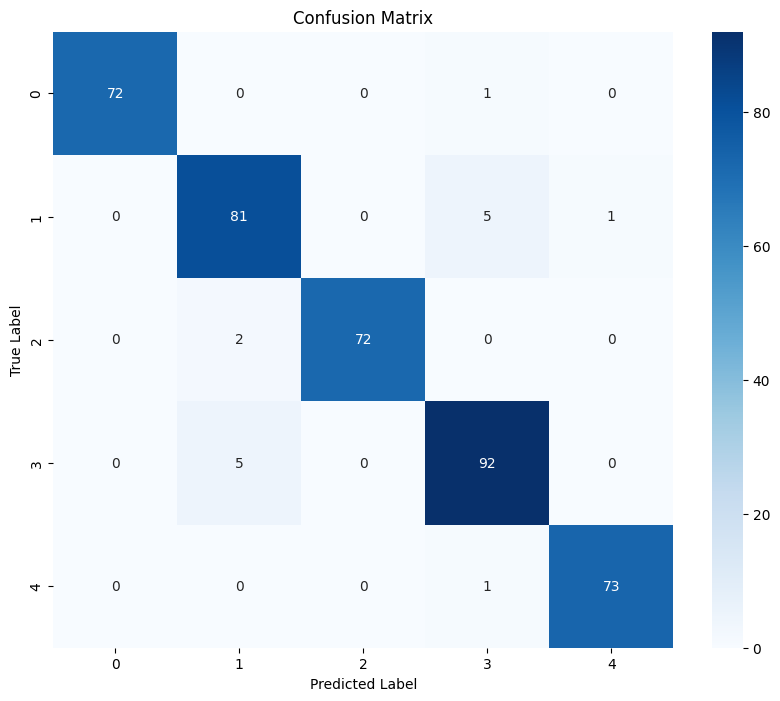

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.99      0.99        73
     Class 1       0.92      0.93      0.93        87
     Class 2       1.00      0.97      0.99        74
     Class 3       0.93      0.95      0.94        97
     Class 4       0.99      0.99      0.99        74

    accuracy                           0.96       405
   macro avg       0.97      0.97      0.97       405
weighted avg       0.96      0.96      0.96       405



In [ ]:
# Validation loop for accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

# Confusion Matrix and Classification Report
all_labels = []
all_predictions = []
model.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)]))

# Completed

# New Start